S0 :: Imports

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import ipynbname#necessary to get filepath to jupyter notebook file

_FILE_DIR = ipynbname.path().parent#obtain directory of this file
_PROJ_DIR = _FILE_DIR.parent.parent#obtain main project directory
_DATA_DIR = _PROJ_DIR / "dataset"
_DATAEXTR_DIR = _PROJ_DIR / "dataExtracted"
_VIS_DIR = _PROJ_DIR / "visualizations"

S1 :: Load dataframes

In [ ]:
mode = 'connectivity'
status = 'targeted'

avgConnectivityDf = pd.read_csv(str(_DATAEXTR_DIR + f"/avg_{mode}_{status}.csv"))

S3 :: Function to filter dataset for relevant iterations and only top 10

In [38]:
def get_top10(n, relative= True):
    
    # set start of the slicing
    start = n-30
    
    if relative:
        ConnDf = (avgConnectivityDf / avgConnectivityDf.iloc[0]).copy()
    else:
        ConnDf = avgConnectivityDf.copy()

    # only get data for chosen period
    idx = list(range(start, n))
    conn_df = pd.DataFrame(ConnDf.loc[idx])

    # sort by the last relevant iteration so that the legend is in order
    return conn_df.T.sort_values(by= n-1, axis= 0, ascending= False)

S4 :: Map each country to a specific color

In [39]:
columns = avgConnectivityDf.columns
colors = sns.color_palette("turbo", len(columns))

col_dict = {columns[i] : colors[i] for i in range(len(columns))}

S5 :: Interaction !!

interactive(children=(IntSlider(value=30, description='Iteration window', max=75, min=30), Checkbox(value=True…

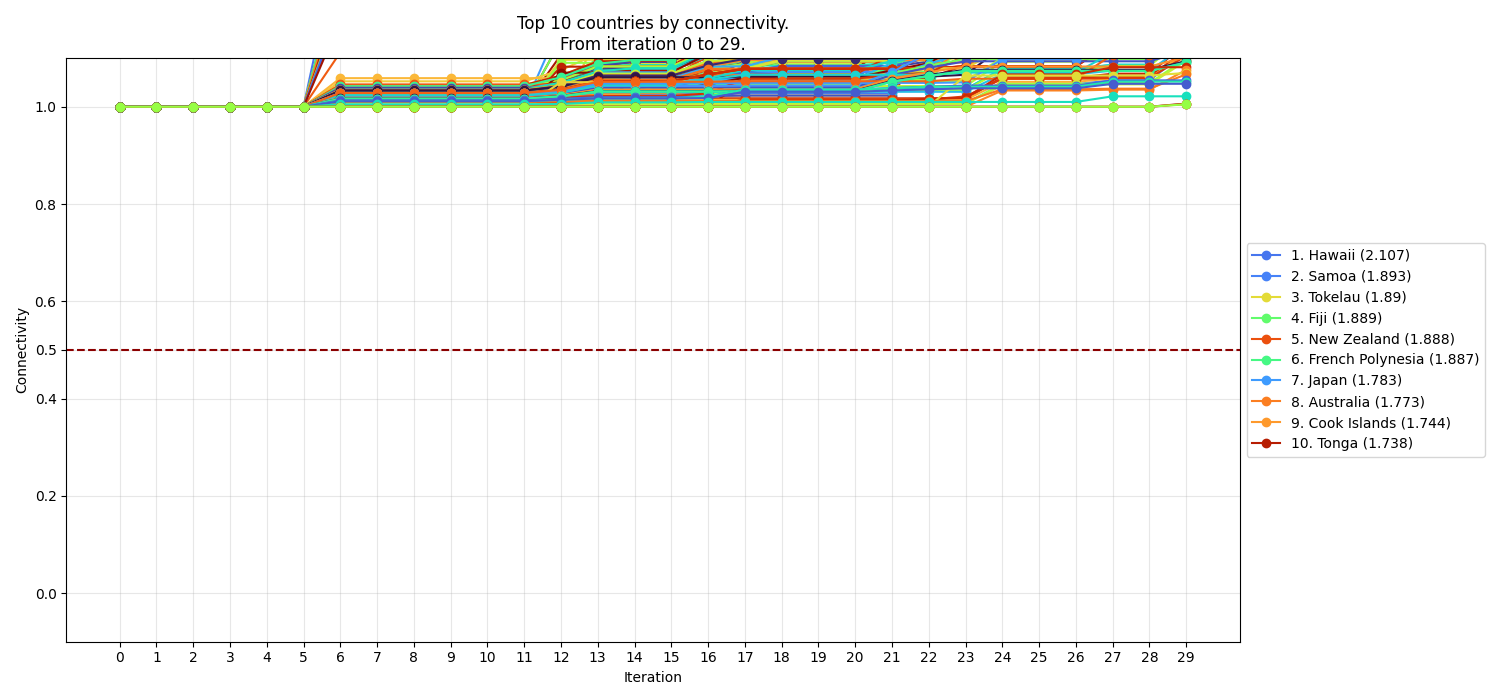

In [40]:
%matplotlib widget

fig, ax = plt.subplots(figsize= (15, 7))

def update_plot(n, relative= True):

    # get entries    
    conn_df = get_top10(n, relative)
    
    # set start
    start = n-30

    ax.clear()
    ax.grid(alpha= 0.3)
    
    # keep track of minimum connectivity to adjust graph lims
    min_pos_conn = np.inf

    # plot lines
    idx = list(range(start, n))
    for i, (_, r) in enumerate(conn_df.iterrows()):
        # use top10 of final iteration to label countries
        if i < 10:

            # update min conn if needed
            min_conn_row = r.values.min()
            if (min_conn_row <= min_pos_conn):
                min_pos_conn = min_conn_row

            l = f"{i+1}. {r.name} ({round(r.values[-1], 3)})" 
        
        # no label for countries outside of the top10
        else:
            l = None

        ax.plot(list(range(len(idx))), r.values, marker= 'o', label= l, c= col_dict[r.name])
    

    ax.set_xticks(list(range(len(idx))), idx)

    if relative:
        ax.set_ylim(-0.1, 1.1)
        ax.set_yticks([0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0])
        ax.axhline(y= 0.5, linestyle= '--', c= 'darkred') 
    else:
        ax.set_ylim(bottom= min_pos_conn-1)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    ax.set_ylabel("Connectivity")
    ax.set_xlabel("Iteration")
    ax.set_title(f"Top 10 countries by connectivity.\nFrom iteration {start} to {n-1}.")
    
    fig.tight_layout()
    fig.canvas.draw_idle()


n_slider = widgets.IntSlider(value= 30, min= 30, max= len(avgConnectivityDf), step= 1, description= 'Iteration window')

interact(update_plot, n= n_slider)
plt.show()